# Sprawdzanie środowiska

In [1]:
from platform import python_version

print(python_version())

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8676721314572919166
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6661821563
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5415755066696400485
physical_device_desc: "device: 0, name: GeForce GTX 1070 Ti, pci bus id: 0000:1f:00.0, compute capability: 6.1"
]


# Przygotowanie odpowiednich danych

In [2]:
# Jeśli zajdzie potrzeba
# from google.colab import drive

# drive.mount('/content/drive')

In [3]:
'''
Dla PoC wykonuje obliczenia dla:
 * '../data/DogsCats'
Folder docelowy:
 * '../data/Photos'
'''

dir_path = '../data/Photos'
A_folder = 'originals'
B_folder = 'photoshops'

# Załadowanie danych

In [4]:
import numpy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import math
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import random
import os

# fix random bo tak ( ͡° ͜ʖ ͡°)
odp = 42
numpy.random.seed(odp)

Using TensorFlow backend.


# Stałe

In [5]:
# Wilkości odpowiednie dla ResNetu

IMAGE_WIDTH=224
IMAGE_HEIGHT=224
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

# Przygotowanie Danych

In [6]:
'''
Opis danych:
1 - klasa 1 -> Originals
0 - klasa 2 -> Photoshops
''' 

A_folder_list = os.listdir(dir_path + '/' + A_folder)
B_folder_list = os.listdir(dir_path + '/' + B_folder)

filenames = []
categories = []

for filename in A_folder_list:
    categories.append(1)
    filenames.append(dir_path + '/' + A_folder + '/' + filename)

for filename in B_folder_list:
    categories.append(0)
    filenames.append(dir_path + '/' + B_folder + '/' + filename)


df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})


In [7]:
# Mieszamy!
df = df.sample(frac=1).reset_index(drop=True)

In [8]:
df.head()

,filename,category
0,../data/Photos/photoshops/co20t8o_0.png,0
1,../data/Photos/photoshops/cb7k2h8_0.jpg,0
2,../data/Photos/photoshops/d23zitu_0.png,0
3,../data/Photos/photoshops/cxevpq7_0.png,0
4,../data/Photos/photoshops/c7st1q3_0.jpg,0


In [9]:
df.shape

(21896, 2)

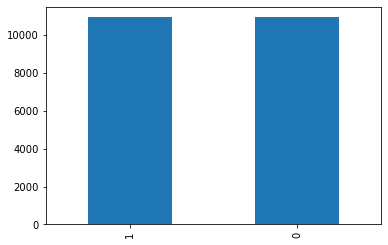

In [10]:
df['category'].value_counts().plot.bar()

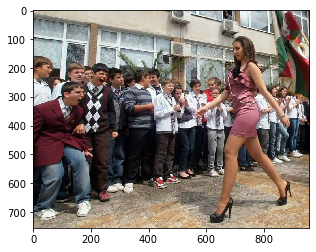

In [11]:
sample = random.choice(df['filename'])
image = load_img(sample)
plt.imshow(image)

# Obróbka danych

In [12]:
 '''
Podział danych z całego df na X i y:

X - wszystko oprócz category
y - category
'''

X, y = df.iloc[:, 0:-1], df.iloc[:, -1]

In [13]:
df.head()

,filename,category
0,../data/Photos/photoshops/co20t8o_0.png,0
1,../data/Photos/photoshops/cb7k2h8_0.jpg,0
2,../data/Photos/photoshops/d23zitu_0.png,0
3,../data/Photos/photoshops/cxevpq7_0.png,0
4,../data/Photos/photoshops/c7st1q3_0.jpg,0


In [14]:
X.head()

,filename
0,../data/Photos/photoshops/co20t8o_0.png
1,../data/Photos/photoshops/cb7k2h8_0.jpg
2,../data/Photos/photoshops/d23zitu_0.png
3,../data/Photos/photoshops/cxevpq7_0.png
4,../data/Photos/photoshops/c7st1q3_0.jpg


In [15]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: category, dtype: int64

In [16]:
# 20% danych do testów
kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = odp)
result = next(kf.split(X, y))

'''
Podział danych z całego df na podstawie splitu

train - 80% danych
test  - 20% danych
'''
train = df.iloc[result[0]]
test =  df.iloc[result[1]]

# Reset indeksów
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

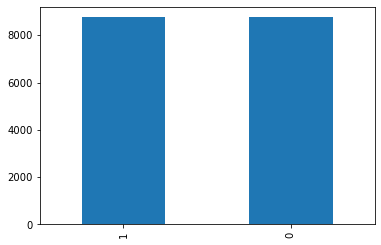

In [17]:
train['category'].value_counts().plot.bar()

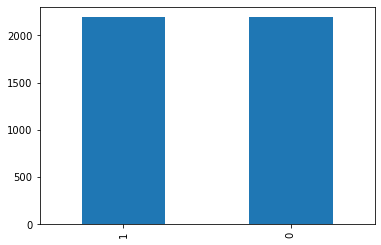

In [18]:
test['category'].value_counts().plot.bar()

In [19]:
print(f'Kształt danych:')
print(f'\t df: {df.shape}')

print(f'\t train: {train.shape}')
print(f'\t test: {test.shape}')

Kształt danych:
	 df: (21896, 2)
	 train: (17516, 2)
	 test: (4380, 2)


In [20]:
# Upewnienie się że dane w train[filename] i test[filename] są stringiem - lepsze dla generatorów

train['filename'] = train['filename'].astype(str) 
test['filename'] = test['filename'].astype(str)

# Upewnienie się że dane w train[category] i test[category] są stringiem - lepsze dla generatorów

train['category'] = train['category'].astype(str) 
test['category'] = test['category'].astype(str)

In [21]:
print(f'Kształt danych:')
print(f'\t df: {df.shape}')

print(f'\t train: {train.shape}')
print(f'\t test: {test.shape}')

Kształt danych:
	 df: (21896, 2)
	 train: (17516, 2)
	 test: (4380, 2)


# Funkcję liczące statystyki

In [22]:
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.models import load_model
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
import keras.backend as K
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score
from sklearn.metrics import recall_score, f1_score, roc_auc_score

In [23]:
def countStats(_y_true, _y_pred):
    accuracy = accuracy_score(_y_true, _y_pred, normalize=True)
    precision = precision_score(_y_true, _y_pred, average='weighted')
    recall = recall_score(_y_true, _y_pred, average='weighted')
    fscore = f1_score(_y_true, _y_pred, average='weighted')
    
    return accuracy, precision, recall, fscore

In [24]:
'''
Źrodło:
https://medium.com/@aakashgoel12/how-to-add-user-defined-function-get-f1-score-in-keras-metrics-3013f979ce0d
'''

def get_f1(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    
    return f1_val

In [25]:
from mlxtend.plotting import plot_confusion_matrix

def plot_cm(cm, classes):
    plot_confusion_matrix(conf_mat=cm,
                          colorbar=True, 
                          show_absolute=True,
                          show_normed=True,
                          class_names=classes)

In [26]:
'''
cb_early_stopper - skończenie uczenia kiedy val_loss nie będzie się poprawiać przez 10 epok
cb_checkpointer - zapis modelu do pliku 'best.h5' modeli o najlepszym(najmniejszym) val_loss
cb_learning_rate_reduction - zmniejszenie LR jeśli val_loss nie będzie się poprawiać przez 5 epok
'''

EARLY_STOP_PATIENCE = 15
LEARNING_RATE_PATIENCE = 5

cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = EARLY_STOP_PATIENCE, verbose=1)
cb_checkpointer = ModelCheckpoint(filepath = 'best.h5', monitor = 'val_loss', save_best_only = True, verbose=1)
cb_learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=LEARNING_RATE_PATIENCE, verbose=1)

# Dobór parametrów

In [27]:
# To Do

batch_size = 10
activation = 'relu'
loss_type = 'categorical_crossentropy'
optimizer = 'Adam'
dropout = 0.25
epochs = 50

# Generatory

In [28]:
'''
Generator dla danych trenningowych
 * losowa rotacja o 15 stopni
 * reskalowanie
 * przybliżenie
 * obrót horyzontalny
 * zakresy dla przesunieć wertykalnych i horyzontalnych
'''

from keras.applications.resnet import preprocess_input

data_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_generator = data_gen.flow_from_dataframe(
    dataframe = train,
    x_col = 'filename',
    y_col = 'category',
    class_mode='categorical',
    target_size=IMAGE_SIZE,
    batch_size=batch_size
)

Found 17516 validated image filenames belonging to 2 classes.


In [29]:
'''
Generator dla danych testowych
 * reskalowanie
'''

test_generator = data_gen.flow_from_dataframe( 
    dataframe = test,
    x_col = 'filename',
    y_col = 'category',
    class_mode='categorical',
    target_size=IMAGE_SIZE,
    batch_size=batch_size
)

Found 4380 validated image filenames belonging to 2 classes.


In [30]:
example_df = train.sample(n=1).reset_index(drop=True)

example_generator = data_gen.flow_from_dataframe(
    dataframe = example_df,
    x_col = 'filename',
    y_col = 'category',
    class_mode='categorical',
    target_size=IMAGE_SIZE,
    batch_size=batch_size
)

Found 1 validated image filenames belonging to 1 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

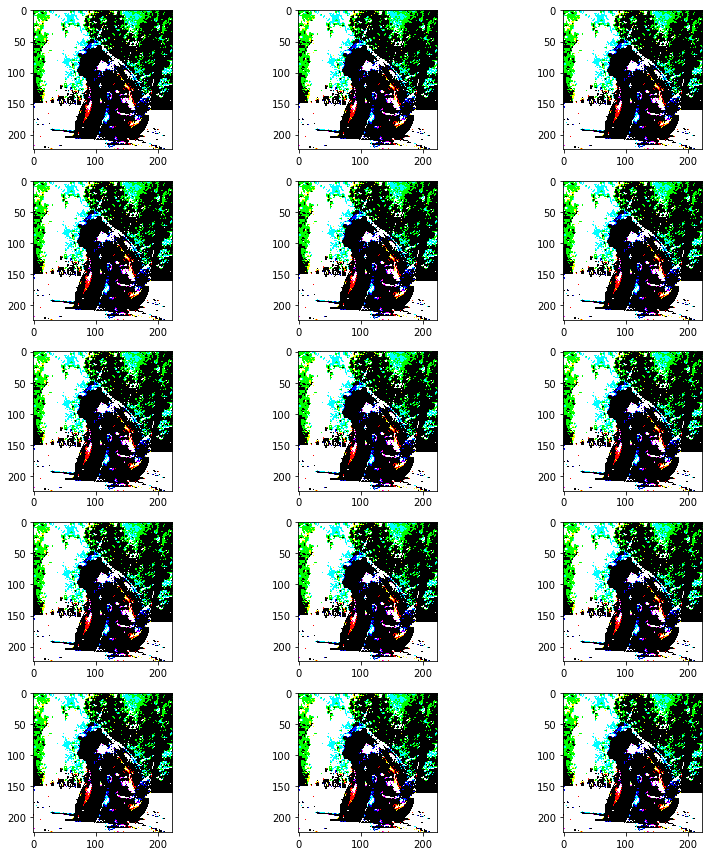

In [31]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

# Model Fine-Tuning

In [32]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from keras.applications.resnet import ResNet50

pre_trained_model_fn = ResNet50(include_top = False, pooling = 'avg', weights = 'imagenet')

for layer in pre_trained_model_fn.layers[:15]:
    layer.trainable = False

for layer in pre_trained_model_fn.layers[15:]:
    layer.trainable = True

model_fn = Sequential()

model_fn.add(pre_trained_model_fn)
model_fn.add(Dense(256, activation=activation))
model_fn.add(Dropout(dropout))
model_fn.add(BatchNormalization())
model_fn.add(Dense(2, activation='softmax'))

model_fn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense_1 (Dense)              (None, 256)               524544    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 514       
Total params: 24,113,794
Trainable params: 23,975,938
Non-trainable params: 137,856
_________________________________________________________________


# ResNet bez żadnych wag wejściowych

In [33]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from keras.applications.resnet import ResNet50

pre_trained_model_v = ResNet50(include_top = True, weights = None, classes=2)

model_v = Sequential()

model_v.add(pre_trained_model_v)

model_v.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2)                 23591810  
Total params: 23,591,810
Trainable params: 23,538,690
Non-trainable params: 53,120
_________________________________________________________________


# Fit

In [34]:
model_fn.compile(loss=loss_type, optimizer=optimizer, metrics=['accuracy', get_f1])

history_fn = model_fn.fit_generator(
    train_generator, 
    epochs = epochs,
    validation_data = test_generator,
    validation_steps = test.shape[0]//batch_size,
    steps_per_epoch = train.shape[0]//batch_size,
    callbacks = [cb_checkpointer, cb_early_stopper, cb_learning_rate_reduction]
)

# Wczytanie najlepszego
model_fn.load_weights('best.h5')

# Zapis
model_fn.save('the_best_fn_P.h5')

Epoch 1/50
 728/1751 [===========>..................] - ETA: 4:15 - loss: 0.7771 - accuracy: 0.5077 - get_f1: 0.5076

d:\programs\python37\lib\site-packages\PIL\Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


1751/1751 [==============================] - 477s 272ms/step - loss: 0.7414 - accuracy: 0.5050 - get_f1: 0.5049 - val_loss: 0.6933 - val_accuracy: 0.5011 - val_get_f1: 0.5011

Epoch 00001: val_loss improved from inf to 0.69326, saving model to best.h5
Epoch 2/50
1751/1751 [==============================] - 464s 265ms/step - loss: 0.7033 - accuracy: 0.4991 - get_f1: 0.4991 - val_loss: 1.0775 - val_accuracy: 0.5164 - val_get_f1: 0.5164

Epoch 00002: val_loss did not improve from 0.69326
Epoch 3/50
1751/1751 [==============================] - 464s 265ms/step - loss: 0.6954 - accuracy: 0.5411 - get_f1: 0.5411 - val_loss: 3.6425 - val_accuracy: 0.5685 - val_get_f1: 0.5685

Epoch 00003: val_loss did not improve from 0.69326
Epoch 4/50
1751/1751 [==============================] - 464s 265ms/step - loss: 0.6886 - accuracy: 0.5604 - get_f1: 0.5604 - val_loss: 0.6397 - val_accuracy: 0.5498 - val_get_f1: 0.5498

Epoch 00004: val_loss improved from 0.69326 to 0.63973, saving model to best.h5
Epoch


Epoch 00033: val_loss did not improve from 0.47383
Epoch 34/50
1751/1751 [==============================] - 462s 264ms/step - loss: 0.6513 - accuracy: 0.6199 - get_f1: 0.6199 - val_loss: 51.0477 - val_accuracy: 0.5989 - val_get_f1: 0.5989

Epoch 00034: val_loss did not improve from 0.47383
Epoch 35/50
1751/1751 [==============================] - 463s 265ms/step - loss: 0.6491 - accuracy: 0.6249 - get_f1: 0.6249 - val_loss: 0.5241 - val_accuracy: 0.5954 - val_get_f1: 0.5954

Epoch 00035: val_loss did not improve from 0.47383
Epoch 36/50
1751/1751 [==============================] - 463s 264ms/step - loss: 0.6477 - accuracy: 0.6285 - get_f1: 0.6285 - val_loss: 0.6597 - val_accuracy: 0.5986 - val_get_f1: 0.5986

Epoch 00036: val_loss did not improve from 0.47383

Epoch 00036: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.
Epoch 00036: early stopping


In [35]:
'''
odświeżenie callbacków
'''

EARLY_STOP_PATIENCE = 15
LEARNING_RATE_PATIENCE = 5

cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = EARLY_STOP_PATIENCE, verbose=1)
cb_checkpointer = ModelCheckpoint(filepath = 'best.h5', monitor = 'val_loss', save_best_only = True, verbose=1)
cb_learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=LEARNING_RATE_PATIENCE, verbose=1)

In [36]:
model_v.compile(loss=loss_type, optimizer=optimizer, metrics=['accuracy', get_f1])

history_v = model_v.fit_generator(
    train_generator, 
    epochs = epochs,
    validation_data = test_generator,
    validation_steps = test.shape[0]//batch_size,
    steps_per_epoch = train.shape[0]//batch_size,
    callbacks = [cb_checkpointer, cb_early_stopper, cb_learning_rate_reduction]
)

# Wczytanie najlepszego
model_v.load_weights('best.h5')

# Zapis
model_v.save('the_best_v_P.h5')

Epoch 1/50
  49/1751 [..............................] - ETA: 13:34 - loss: 1.4128 - accuracy: 0.5449 - get_f1: 0.5449

d:\programs\python37\lib\site-packages\PIL\Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


1751/1751 [==============================] - 539s 308ms/step - loss: 0.7659 - accuracy: 0.5160 - get_f1: 0.5160 - val_loss: 0.7238 - val_accuracy: 0.4954 - val_get_f1: 0.4954

Epoch 00001: val_loss improved from inf to 0.72382, saving model to best.h5
Epoch 2/50
1751/1751 [==============================] - 521s 298ms/step - loss: 0.7189 - accuracy: 0.5158 - get_f1: 0.5157 - val_loss: 0.6432 - val_accuracy: 0.5306 - val_get_f1: 0.5306

Epoch 00002: val_loss improved from 0.72382 to 0.64315, saving model to best.h5
Epoch 3/50
1751/1751 [==============================] - 519s 296ms/step - loss: 0.7110 - accuracy: 0.5211 - get_f1: 0.5211 - val_loss: 0.8700 - val_accuracy: 0.5626 - val_get_f1: 0.5626

Epoch 00003: val_loss did not improve from 0.64315
Epoch 4/50
1751/1751 [==============================] - 519s 296ms/step - loss: 0.7020 - accuracy: 0.5162 - get_f1: 0.5162 - val_loss: 0.7227 - val_accuracy: 0.5276 - val_get_f1: 0.5276

Epoch 00004: val_loss did not improve from 0.64315
Epoch

1751/1751 [==============================] - 518s 296ms/step - loss: 0.6686 - accuracy: 0.5832 - get_f1: 0.5832 - val_loss: 0.7663 - val_accuracy: 0.5925 - val_get_f1: 0.5925

Epoch 00033: val_loss did not improve from 0.53778

Epoch 00033: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.
Epoch 34/50
1751/1751 [==============================] - 518s 296ms/step - loss: 0.6685 - accuracy: 0.5865 - get_f1: 0.5865 - val_loss: 0.7723 - val_accuracy: 0.5913 - val_get_f1: 0.5913

Epoch 00034: val_loss did not improve from 0.53778
Epoch 35/50
1751/1751 [==============================] - 518s 296ms/step - loss: 0.6693 - accuracy: 0.5854 - get_f1: 0.5854 - val_loss: 0.9142 - val_accuracy: 0.5911 - val_get_f1: 0.5911

Epoch 00035: val_loss did not improve from 0.53778
Epoch 36/50
1751/1751 [==============================] - 518s 296ms/step - loss: 0.6687 - accuracy: 0.5860 - get_f1: 0.5860 - val_loss: 0.6260 - val_accuracy: 0.5879 - val_get_f1: 0.5879

Epoch 00036: val_loss did 

# Statystyki

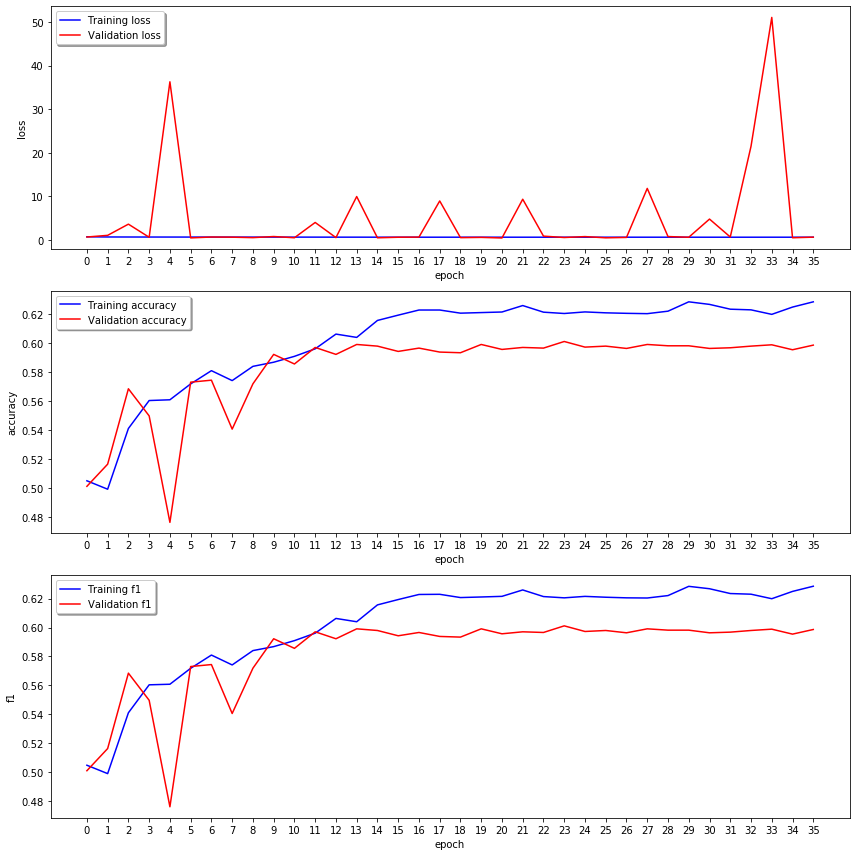

In [37]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 12))

# Wykres loss
ax1.plot(history_fn.history['loss'], color='b', label="Training loss")
ax1.plot(history_fn.history['val_loss'], color='r', label="Validation loss")
ax1.set_xticks(numpy.arange(0, len(history_fn.history['val_loss']), 1))
ax1.legend(loc='best', shadow=True)
ax1.set_ylabel('loss')
ax1.set_xlabel('epoch')

# Wykres accuracy
ax2.plot(history_fn.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history_fn.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(numpy.arange(0, len(history_fn.history['val_accuracy']), 1))
ax2.legend(loc='best', shadow=True)
ax2.set_ylabel('accuracy')
ax2.set_xlabel('epoch')

# Wykres F1
ax3.plot(history_fn.history['get_f1'], color='b', label="Training f1")
ax3.plot(history_fn.history['val_get_f1'], color='r',label="Validation f1")
ax3.set_xticks(numpy.arange(0, len(history_fn.history['get_f1']), 1))
ax3.legend(loc='best', shadow=True)
ax3.set_ylabel('f1')
ax3.set_xlabel('epoch')


plt.tight_layout()
plt.show()

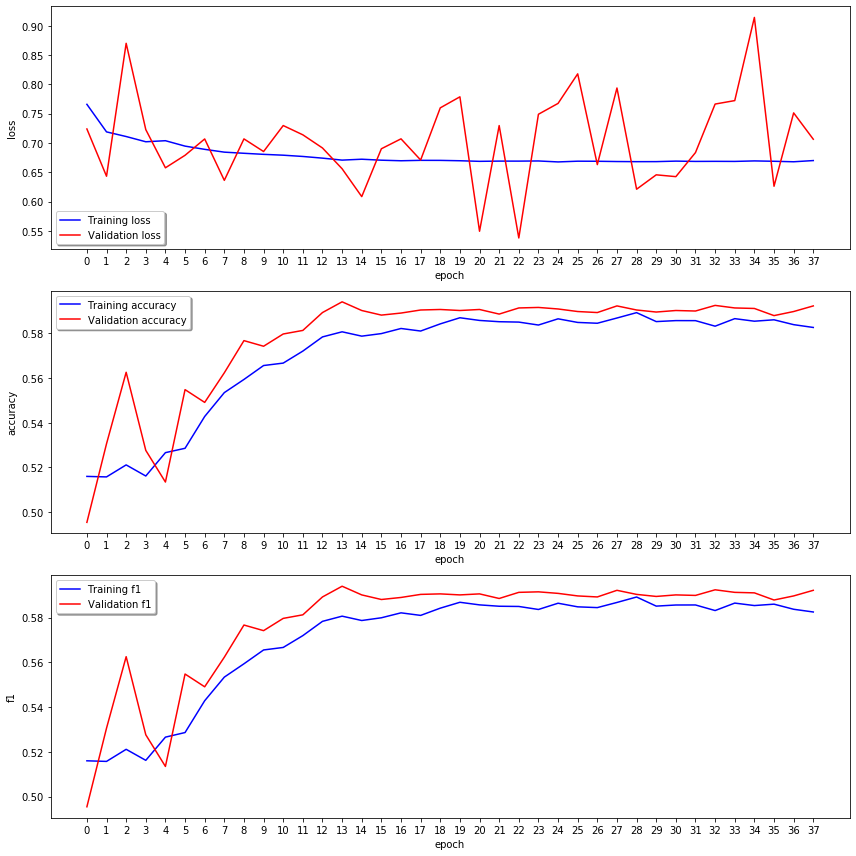

In [38]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 12))

# Wykres loss
ax1.plot(history_v.history['loss'], color='b', label="Training loss")
ax1.plot(history_v.history['val_loss'], color='r', label="Validation loss")
ax1.set_xticks(numpy.arange(0, len(history_v.history['val_loss']), 1))
ax1.legend(loc='best', shadow=True)
ax1.set_ylabel('loss')
ax1.set_xlabel('epoch')

# Wykres accuracy
ax2.plot(history_v.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history_v.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(numpy.arange(0, len(history_v.history['val_accuracy']), 1))
ax2.legend(loc='best', shadow=True)
ax2.set_ylabel('accuracy')
ax2.set_xlabel('epoch')

# Wykres F1
ax3.plot(history_v.history['get_f1'], color='b', label="Training f1")
ax3.plot(history_v.history['val_get_f1'], color='r',label="Validation f1")
ax3.set_xticks(numpy.arange(0, len(history_v.history['get_f1']), 1))
ax3.legend(loc='best', shadow=True)
ax3.set_ylabel('f1')
ax3.set_xlabel('epoch')


plt.tight_layout()
plt.show()

In [39]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def countStats(_y_true, _y_pred):
    accuracy = accuracy_score(_y_true, _y_pred, normalize=True)
    precision = precision_score(_y_true, _y_pred, average='weighted')
    recall = recall_score(_y_true, _y_pred, average='weighted')
    fscore = f1_score(_y_true, _y_pred, average='weighted')
    
    return accuracy, precision, recall, fscore

In [40]:
stats_df = pd.DataFrame({
    'filename': test['filename'],
    'category': test['category'],
    'predict_fn': None,
    'predict_v': None
})

# Mieszamy!
stats_df = stats_df.sample(frac=1).reset_index(drop=True)

stats_df.head()

,filename,category,predict_fn,predict_v
0,../data/Photos/originals/6588pa.jpg,1,None,None
1,../data/Photos/photoshops/c8c91j4_0.jpg,0,None,None
2,../data/Photos/photoshops/d4qa93b_0.jpg,0,None,None
3,../data/Photos/originals/7b5cpd.jpg,1,None,None
4,../data/Photos/photoshops/ckz1ae8_0.jpg,0,None,None


In [41]:
validate_generator = data_gen.flow_from_dataframe( 
    dataframe = stats_df,
    x_col = 'filename',
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 4380 validated image filenames.


In [42]:
predict_fn = model_fn.predict_generator(validate_generator, verbose=True)

predict_v = model_v.predict_generator(validate_generator, verbose=True)

438/438 [==============================] - 57s 129ms/step


In [43]:
# Zamiana z one hot encodera na jedno wyjście
stats_df['predict_fn'] = numpy.argmax(predict_fn, axis=-1)
stats_df['predict_v'] = numpy.argmax(predict_v, axis=-1)

In [44]:
stats_df.head()

,filename,category,predict_fn,predict_v
0,../data/Photos/originals/6588pa.jpg,1,1,1
1,../data/Photos/photoshops/c8c91j4_0.jpg,0,1,1
2,../data/Photos/photoshops/d4qa93b_0.jpg,0,1,1
3,../data/Photos/originals/7b5cpd.jpg,1,1,0
4,../data/Photos/photoshops/ckz1ae8_0.jpg,0,0,0


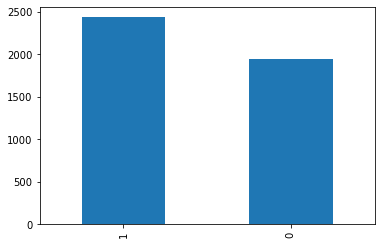

In [45]:
stats_df['predict_fn'].value_counts().plot.bar()

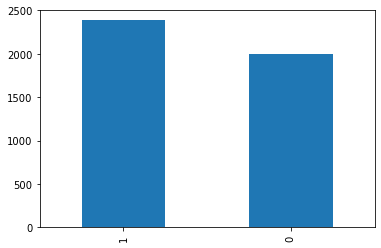

In [46]:
stats_df['predict_v'].value_counts().plot.bar()

In [47]:
y_true_fn = stats_df['category'].to_numpy().astype(int)
y_pred_fn = stats_df['predict_fn'].to_numpy().astype(int)

y_true_v = stats_df['category'].to_numpy().astype(int)
y_pred_v = stats_df['predict_v'].to_numpy().astype(int)

In [48]:
cm_fn = confusion_matrix(y_true_fn, y_pred_fn)
cm_v = confusion_matrix(y_true_v, y_pred_v)

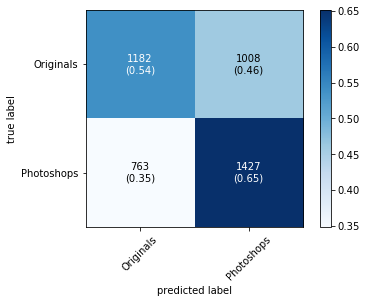

In [59]:
plot_cm(cm_fn, ['Originals', 'Photoshops'])

In [50]:
print(cm_fn)

[[1182 1008]
 [ 763 1427]]


In [51]:
loss, accuracy, get_f1  = model_fn.evaluate_generator(test_generator, verbose=True)

438/438 [==============================] - 57s 131ms/step


In [52]:
print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')
print(f'Test F1: {get_f1:.3}')

Test loss: 3.54
Test accuracy: 0.596
Test F1: 0.596


In [53]:
accuracy, precision, recall, fscore = countStats(y_true_fn, y_pred_fn)
print(f'Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF-score: {fscore}')

Accuracy: 0.595662100456621
Precision: 0.5968745216239186
Recall: 0.595662100456621
F-score: 0.5943930193797183


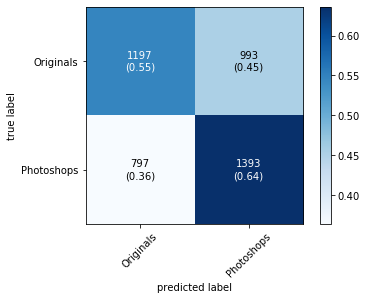

In [54]:
plot_cm(cm_v, ['Originals', 'Photoshops'])

In [55]:
print(cm_v)

[[1197  993]
 [ 797 1393]]


In [56]:
loss, accuracy, get_f1  = model_v.evaluate_generator(test_generator, verbose=True)

438/438 [==============================] - 57s 130ms/step


In [57]:
print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')
print(f'Test F1: {get_f1:.3}')

Test loss: 0.593
Test accuracy: 0.591
Test F1: 0.591


In [58]:
accuracy, precision, recall, fscore = countStats(y_true_v, y_pred_v)
print(f'Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF-score: {fscore}')

Accuracy: 0.591324200913242
Precision: 0.5920615997195274
Recall: 0.591324200913242
F-score: 0.5905042018211235
